In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import m_p, m_e, c
import gappa as gp
from gammapy.catalog import SourceCatalogGammaCat
from astropy.io import fits
from gammapy.modeling.models import create_crab_spectral_model as CrabSpectrum


In [5]:
emin, emax = 1, 1000
prec = 1e1

In [6]:
all_p = fits.open('synt.fits')

In [7]:
dati = all_p[1].data

In [8]:
# dati = (dati[np.abs(dati.Glat) <= 2])

In [9]:
def plotLogNlogS(fl, binning, density=False, label=None, color='C0'):
    fl = np.nan_to_num(fl)
#     logs_min = np.int(np.floor(np.log10(np.min(fl))))
    logs_min = -5
#     logs_max = np.int(np.ceil(np.log10(np.max(fl))))
    logs_max = 1
    nbins = binning*(logs_max - logs_min)
    bins_lognlogs = np.logspace(logs_min, logs_max, nbins)
    if label==None:
        n, bins, patches = plt.hist(fl, bins=bins_lognlogs, density=density, histtype='step', cumulative=-1, lw=2)
    else:
        n, bins, patches = plt.hist(fl, bins=bins_lognlogs, density=density, histtype='step', cumulative=-1, lw=2)
    f = np.sqrt(bins[1:] * bins[:-1])
    # shaded band with Poisson uncertainties
    plt.fill_between(f, n - np.sqrt(n), n + np.sqrt(n), color=color, label=label,
                     alpha=0.3)

    plt.loglog()
    return n, bins

In [10]:
# compute integral flux in crab units
crab = CrabSpectrum('meyer')#.model
# crab = CrabSpectrum('meyer')
emin0 = 0.1 * u.TeV
emin1, emax = [1, 1000] * u.TeV

emin10 = 10. * u.TeV

crab_01_1000 = crab.integral(emin0, emax).value
crab_1_1000 = crab.integral(emin1, emax).value
crab_10_1000 = crab.integral(emin10, emax).value


# crab_flux_1TeV = crab.integral(1*u.TeV, emax).value
# remormalize crab flux so that it matches the Meyer model > 1 TeV (consistent with gamma-cat)
# crab_1_10 *= 2.0744340476909142e-11 / crab_flux_1TeV
flux_01TeV = (dati.F01 / crab_01_1000)
flux_1TeV = (dati.F1 / crab_1_1000)
flux_10TeV = (dati.F10 / crab_10_1000)


In [11]:
dati.columns

ColDefs(
    name = 'Glon'; format = 'D'
    name = 'Glat'; format = 'D'
    name = 'Distance'; format = 'D'; unit = 'kpc'
    name = 'Class'; format = '3A'
    name = 'F01'; format = 'D'; unit = 'cm-2 s-1'
    name = 'F1'; format = 'D'; unit = 'cm-2 s-1'
    name = 'F10'; format = 'D'; unit = 'cm-2 s-1'
)

In [12]:
dic = {'type' : dati.Class,
       'F01': flux_01TeV,
       'F1': flux_1TeV,
       'F10': flux_10TeV}

In [13]:
dati_pd = pd.DataFrame(dic)

In [14]:
len(dati_pd[dati_pd.type == 'Pwn'])

1299

(0.0001, 19.952623149688797)

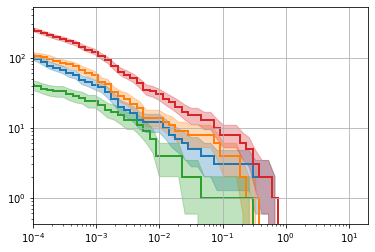

In [11]:
a = plotLogNlogS(dati_pd.F01[dati_pd.type == 'Pwn'], 10, density=False, label=None, color='C0')
a = plotLogNlogS(dati_pd.F01[dati_pd.type == 'Snr'][dati_pd.F01 < 5.], 10, density=False, label=None, color='C1')
a = plotLogNlogS(dati_pd.F01[dati_pd.type == 'iSR'], 10, density=False, label=None, color='C2')
a = plotLogNlogS(dati_pd.F01[dati_pd.F01 < 5.], 10, density=False, label=None, color='C3')

plt.grid()
plt.xlim(1e-4)

(0.0001, 19.952623149688797)

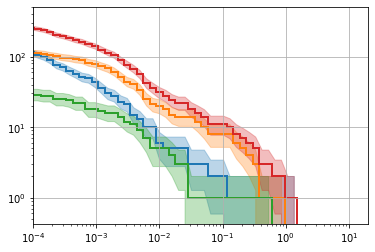

In [12]:
a = plotLogNlogS(dati_pd.F1[dati_pd.type == 'Pwn'], 10, density=False, label=None, color='C0')
a = plotLogNlogS(dati_pd.F1[dati_pd.type == 'Snr'][dati_pd.F1 < 5.], 10, density=False, label=None, color='C1')
a = plotLogNlogS(dati_pd.F1[dati_pd.type == 'iSR'], 10, density=False, label=None, color='C2')
a = plotLogNlogS(dati_pd.F1[dati_pd.F1 < 5.], 10, density=False, label=None, color='C3')

plt.grid()
plt.xlim(1e-4)

(0.0001, 19.952623149688797)

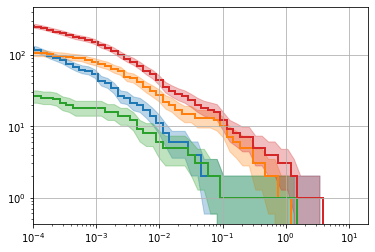

In [13]:
a = plotLogNlogS(dati_pd.F10[dati_pd.type == 'Pwn'], 10, density=False, label=None, color='C0')
a = plotLogNlogS(dati_pd.F10[dati_pd.type == 'Snr'][dati_pd.F10 < 5.], 10, density=False, label=None, color='C1')
a = plotLogNlogS(dati_pd.F10[dati_pd.type == 'iSR'], 10, density=False, label=None, color='C2')
a = plotLogNlogS(dati_pd.F10[dati_pd.F10 < 5.], 10, density=False, label=None, color='C3')

plt.grid()
plt.xlim(1e-4)

In [14]:
gammacat_file = 'gammacat.fits.gz'

In [15]:
def flux_from_gammacat(cat,emin=1,emax=1000):
    # calculate integral flux in desired energy range from spectral model
    fluxes = np.array([])
    a = 0
    for source in cat:
        try:
            a += 1
            print(a, end='\r')
            if np.abs(source.spatial_model().lat_0.value) <= 2.:
                try:
                    flux = source.spectral_model().integral(emin*u.TeV,emax*u.TeV)
                    fluxes = np.append(fluxes,flux.value)
                except:
                    # sources without spectral model
                    fluxes = np.append(fluxes, np.nan)
            else:
                fluxes = np.append(fluxes, np.nan)
        except:
            fluxes = np.append(fluxes, np.nan)
        
    crab = CrabSpectrum('meyer')
    # calculate crab flux over the desired energy range
    crab_flux = crab.integral(emin*u.TeV, emax*u.TeV).value
    crab_flux_1TeV = crab.integral(1*u.TeV, 1000.*u.TeV).value
    # remormalize crab flux so that it matches the Meyer model > 1 TeV (consistent with gamma-cat)
#     crab_flux *= 2.0744340476909142e-11 / crab_flux_1TeV
    fluxes /= crab_flux
    return fluxes

In [17]:
gammacat = SourceCatalogGammaCat(gammacat_file)

In [18]:
samples = [ {'name' : 'gal', 'where' : ['gal']}]

In [19]:
fluxes1 = flux_from_gammacat(gammacat, emin=1,emax=1000)
fluxes01 = flux_from_gammacat(gammacat, emin=0.1,emax=1000)
fluxes10 = flux_from_gammacat(gammacat, emin=10, emax=1000)


In [20]:
len(fluxes1)

166

In [21]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


(0.39806199042692636, 1000.0)

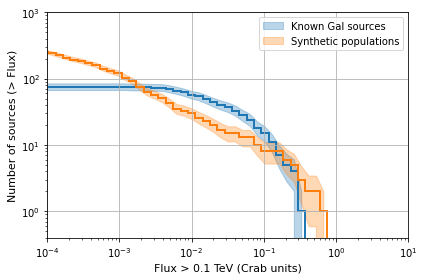

In [23]:
# for s, sample in enumerate(samples[:]):
#     # build mask to select desired sample
#     mask = np.zeros(len(gammacat.table),dtype=bool)
#     for c in sample['where']:
#         mask = np.logical_or(mask,gammacat.table['where'] == c)
#     # select sample
#     flux_sample = fluxes01[mask==True]
#     aa = plotLogNlogS(flux_sample, 10, label='Known Gal sources', color=color_cycle[s])
ss = plotLogNlogS(fluxes01, 10, label='Known Gal sources', color='C0')
aa = plotLogNlogS(dati_pd.F01[dati_pd.F01<5.], 10, color='C1', label='Synthetic populations')
plt.legend()
plt.xlim(1e-4, 1e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 0.1 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_01TeV_allgal.png', dpi=200, bbox_inches='tight')
plt.ylim()

(0.39806199042692636, 1000.0)

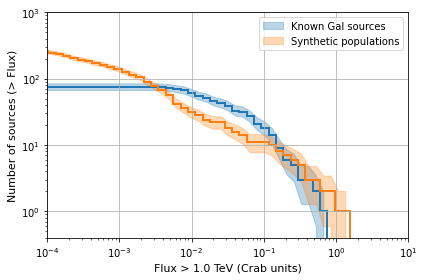

In [24]:
ss = plotLogNlogS(fluxes1, 10, label='Known Gal sources', color='C0')
aa = plotLogNlogS(dati_pd.F1[dati_pd.F1<5.], 10, color='C1', label='Synthetic populations')
plt.legend()
plt.xlim(1e-4, 1e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_1TeV_allgal.png', dpi=200, bbox_inches='tight')
plt.ylim()


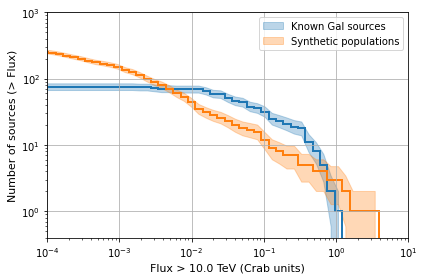

In [25]:
ss = plotLogNlogS(fluxes10, 10, label='Known Gal sources', color='C0')
aa = plotLogNlogS(dati_pd.F10[dati_pd.F10<5], 10, color='C1', label='Synthetic populations')
plt.legend()
plt.xlim(1e-4, 1e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 10.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_10TeV_allgal.png', dpi=200, bbox_inches='tight')


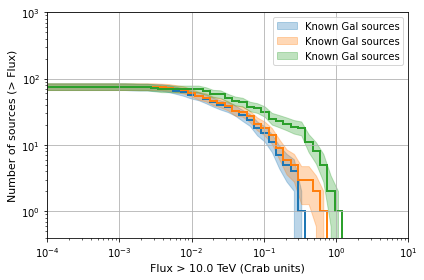

In [26]:
ss = plotLogNlogS(fluxes01, 10, label='Known Gal sources', color='C0')
ss = plotLogNlogS(fluxes1, 10, label='Known Gal sources', color='C1')
ss = plotLogNlogS(fluxes10, 10, label='Known Gal sources', color='C2')

    
    
plt.legend()
plt.xlim(1e-4, 1e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 10.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()

In [27]:
samples1 = [ {'name' : 'PWNe', 'classes' : ['pwn']},
            {'name' : 'PWNe + composites', 'classes' : ['pwn','pwn,snr']},
            {'name' : 'PWNe + composites + UNID', 'classes' : ['pwn','pwn,snr','unid']}
            ]

(0.39806199042692636, 1000.0)

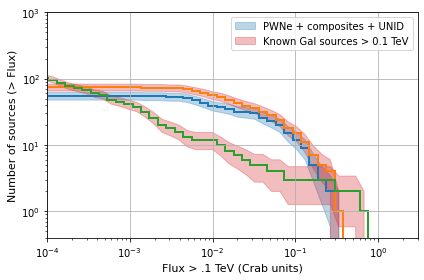

In [28]:
for s, sample in enumerate(samples1[2:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes01[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])

for c in samples[0]['where']:
    mask = np.logical_or(mask,gammacat.table['where'] == c)
flux_sample = fluxes01[mask==True]
aa = plotLogNlogS(flux_sample, 10, label='Known Gal sources > 0.1 TeV', color='C3')
a = plotLogNlogS(dati_pd.F01[dati_pd.type == 'Pwn'], 10, density=False, label=None, color='C3')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > .1 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('gammacatlogNlogS_01TeV_gal_plusPWNe.png', dpi=200, bbox_inches='tight')
plt.ylim()


(0.39806199042692636, 1000.0)

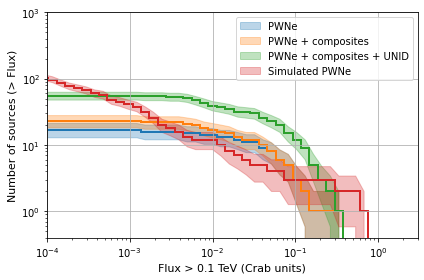

In [29]:
for s, sample in enumerate(samples1[:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes01[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])

a = plotLogNlogS(dati_pd.F01[dati_pd.type == 'Pwn'], 10, density=False, color='C3', label='Simulated PWNe')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 0.1 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_01TeV_pwne.png', dpi=200, bbox_inches='tight')
plt.ylim()


(0.39806199042692636, 1000.0)

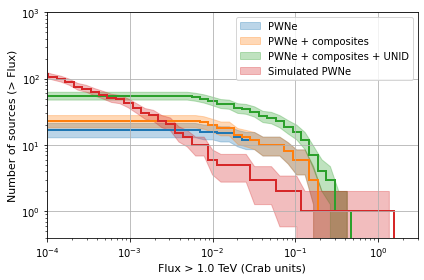

In [30]:
for s, sample in enumerate(samples1[:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes1[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])

a = plotLogNlogS(dati_pd.F1[dati_pd.type == 'Pwn'], 10, density=False, label='Simulated PWNe', color='C3')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_1TeV_pwne.png', dpi=200, bbox_inches='tight')
plt.ylim()


In [31]:
samples2 = [ {'name' : 'SNR', 'classes' : ['snr']},
            {'name' : 'SNR + composites', 'classes' : ['snr','pwn,snr']},
            {'name' : 'SNR + composites + other', 'classes' : ['snr','pwn,snr','snr,mc', 'unid,snr,mc']}
            ]

In [32]:
list(dict.fromkeys((list(gammacat.table['classes']))))

['pwn,snr',
 'hbl',
 'snr',
 'galaxy',
 'pwn',
 'blazar',
 'ibl',
 'unid',
 'bin',
 'fri',
 'snr,mc',
 'psr',
 'other',
 'psr,pwn',
 'fsrq',
 'lbl',
 'unid,snr,mc',
 'unid,gc',
 'unid,pwn',
 'bin,unid',
 'pwn,unid']

(0.39806199042692636, 1000.0)

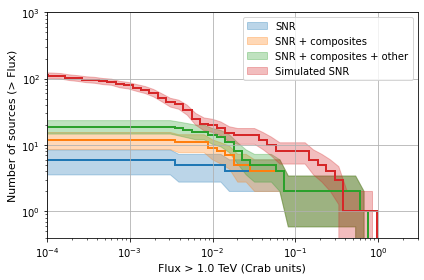

In [33]:
for s, sample in enumerate(samples2[:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes1[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])

a = plotLogNlogS(dati_pd.F1[dati_pd.type == 'Snr'][dati_pd.F1 < 4.], 10, density=False, label='Simulated SNR', color='C3')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_1TeV_SNR.png', dpi=200, bbox_inches='tight')
plt.ylim()


(0.39806199042692636, 1000.0)

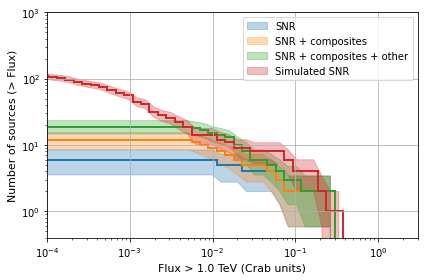

In [34]:
for s, sample in enumerate(samples2[:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes01[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])

a = plotLogNlogS(dati_pd.F01[dati_pd.type == 'Snr'][dati_pd.F01 < 4.], 10, density=False, label='Simulated SNR', color='C3')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('final_pop_logNlogS_1TeV_SNR.png', dpi=200, bbox_inches='tight')
plt.ylim()